# Sound speed as a source of modified gravity

In Horndeski theory, the dark energy sound speed is given by the basis functions $\alpha_M$, $\alpha_B$, $\alpha_K$ and $\alpha_T$:

\begin{equation}
    c_s^2 = \frac{1}{\alpha_K + \frac{3}{2}\alpha_B^2}\left[ (2 - \alpha_B)\left(-\frac{H'}{aH^2} + \frac{\alpha_B}{2}(1 + \alpha_T) + \alpha_M - \alpha_T\right) - \frac{3(\rho_\mathrm{tot} + P_\mathrm{tot})}{H^2M_*^2} + \frac{\alpha_B'}{aH}\right].
\end{equation}

The term $\alpha_T$ is assumed to be zero. We can further assume $M_* = 1$, implying $\alpha_M = 0$. We obtain:

\begin{equation}
    c_s^2 = \frac{1}{\alpha_K + \frac{3}{2}\alpha_B^2}\left[ (2 - \alpha_B)\left(-\frac{H'}{aH^2} + \frac{\alpha_B}{2}\right) - \frac{3(\rho_\mathrm{tot} + P_\mathrm{tot})}{H^2} + \frac{\alpha_B'}{aH}\right].
\end{equation}

This equation can be inverted, isolating $\alpha_B'$:

\begin{equation}
    \left(\alpha_K + \frac{3}{2}\alpha_B^2 \right)c_s^2 = (2 - \alpha_B)\left(-\frac{H'}{aH^2} + \frac{\alpha_B}{2}\right) - \frac{3(\rho_\mathrm{tot} + P_\mathrm{tot})}{H^2} + \frac{\alpha_B'}{aH},
\end{equation}

\begin{equation}
    \frac{\alpha_B'}{aH} = \frac{d\alpha_B}{d\ln a} = \left(\alpha_K + \frac{3}{2}\alpha_B^2 \right)c_s^2 + (\alpha_B - 2)\left(-\frac{H'}{aH^2} + \frac{\alpha_B}{2} \right) + \frac{3(\rho_\mathrm{tot} + P_\mathrm{tot})}{H^2}.
\end{equation}

Inserting some background properties,

\begin{equation}
    H^2 = \frac{\rho}{3}; \;\; \dot{H} + H^2 = -\frac{1}{6}(\rho + 3P),
\end{equation}

we find

\begin{equation}
    \frac{\alpha_B'}{aH} = \frac{d\alpha_B}{d\ln a} = \left(\alpha_K + \frac{3}{2}\alpha_B^2 \right)c_s^2 + (\alpha_B - 2)\left(\frac{3}{2}(1 + w_t) + \frac{\alpha_B}{2} \right) + 9(1 + w_t).
\end{equation}

In terms of the $\mu-\Sigma$ parametrization, we find

\begin{equation}
    \mu = \Sigma = 1 + \frac{\alpha_B}{2c_s^2\left(\alpha_K + \frac{3}{2}\alpha_B^2\right)}
\end{equation}

In [1]:
import numpy as np
import camb
from scipy.interpolate import interp1d
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

In [188]:
def rho_de(a, w0, wa, omega_de):
    return omega_de*a**(-3*(1 + w0 + wa))*np.exp(-3*wa*(1-a))

def rho_m(a, omega_m):
    return omega_m*a**-3

def rho_gamma(a, omega_r):
    return omega_r*a**-4

def w_tot(a, omega_m, omega_de, omega_r, w0, wa):
    w_de = w0 + wa*(1-a)
    rhog = rho_gamma(a, omega_r)
    rhom = rho_m(a, omega_m)
    rhode = rho_de(a, w0, wa, omega_de)
    rhotot = rhog + rhode + rhom
    return (rhog/3 + w_de*rhode)/rhotot, ((4/3)*rhog + rhom)/rhotot # NOTE: last term is (rho_no_de + P_no_de)/rho_tot

def deriv(loga, alpha_B, alpha_K=1, cs2=1, omega_m=0.3, omega_r=2.5e-5, w0=-1, wa=0):
    omega_de = 1 - omega_m - omega_r
    a = np.exp(loga)
    wt, last_term = w_tot(a, omega_m, omega_de, omega_r, w0, wa)
    return cs2*(alpha_K + 1.5*alpha_B**2) + (alpha_B - 2)*(1.5*(1 + wt) + 0.5*alpha_B) + 9*last_term

def solve_alpha_B(alpha_K, cs2, omega_m, omega_r, w0, wa, alpha_B_init=0, method="scipy"):
    a_ini = 1e-5
    a_final = 1
    # print(deriv(np.log(a_ini), alpha_B_init, alpha_K, cs2, omega_m, omega_r, w0, wa))
    if method == "scipy":
        return solve_ivp(deriv, (np.log(a_ini), np.log(a_final)), y0=(alpha_B_init,),  args=(alpha_K, cs2, omega_m, omega_r, w0, wa))
    elif method == "euler":
        alpha_B = alpha_B_init
        N = 200 # Number of steps
        dloga = (np.log(a_final) - np.log(a_ini))/N
        result = [alpha_B]
        loga = np.linspace(np.log(a_ini), np.log(a_final), N+1)
        for i in range(N):
            alpha_B += deriv(loga[i], alpha_B, alpha_K, cs2, omega_m, omega_r, w0, wa)*dloga
            result.append(alpha_B)
        return result, loga
    else:
        raise Exception("Unknown method")
    
def study_alpha_B(alpha_K, cs2, omega_m, omega_r, w0, wa):
    N_loga = 100 # Number of steps
    a_ini = 1e-5
    loga = np.linspace(np.log(a_ini), 0, N_loga)
    N_alpha_B = 100
    alpha_B = np.linspace(-10, 10, N_alpha_B)
    result = np.zeros((N_loga, N_alpha_B))
    for i in range(N_loga):
        for j in range(N_alpha_B):
            result[i, j] = deriv(loga[i], alpha_B[j], alpha_K, cs2, omega_m, omega_r, w0, wa)
    return result, loga*np.log10(np.e), alpha_B

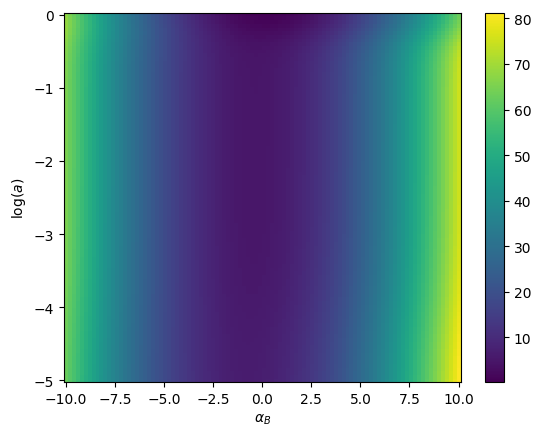

In [189]:
derivs, loga, alpha_B = study_alpha_B(alpha_K=-10, cs2=0.1, omega_m=0.3, omega_r=2.5e-5, w0=-0.7, wa=-0.5)
plt.pcolormesh(alpha_B, loga, derivs)
plt.xlabel("$\\alpha_B$")
plt.ylabel("$\\log(a)$")
plt.colorbar()

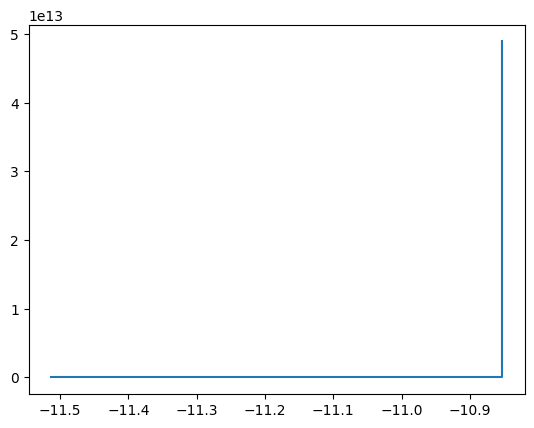

In [190]:
result = solve_alpha_B(alpha_K=-10, cs2=0.1, omega_m=0.3, omega_r=2.5e-5, w0=-0.7, wa=-0.5)
plt.plot(result.t, result.y[0])

In [167]:
solve_alpha_B(alpha_K=-10, cs2=0.1, omega_m=0.3, omega_r=2.5e-5, w0=-0.7, wa=-0.5, method="euler", alpha_B_init=0)

([0,
  np.float64(-0.35635245486812617),
  np.float64(-0.7268777095815242),
  np.float64(-1.1019363227453645),
  np.float64(-1.470971773429958),
  np.float64(-1.8236323985395755),
  np.float64(-2.150921235909883),
  np.float64(-2.4461086573732884),
  np.float64(-2.705211264055124),
  np.float64(-2.9269808923700316),
  np.float64(-3.1124921360541165),
  np.float64(-3.2645033158821275),
  np.float64(-3.3867734483142558),
  np.float64(-3.4834680498542974),
  np.float64(-3.558718226896946),
  np.float64(-3.616340639047034),
  np.float64(-3.6596925983729216),
  np.float64(-3.69162468363746),
  np.float64(-3.714494956171598),
  np.float64(-3.7302165884026603),
  np.float64(-3.7403194988698196),
  np.float64(-3.746014043641303),
  np.float64(-3.748250250271054),
  np.float64(-3.74776964563534),
  np.float64(-3.745148862639576),
  np.float64(-3.740835365979704),
  np.float64(-3.735176176965149),
  np.float64(-3.72844065809196),
  np.float64(-3.720838405996982),
  np.float64(-3.7125331978647713

## Using CAMB

In [131]:
# Example cosmology
H0 = 67
Omega_m = 0.319
Omega_b = 0.049
As = 2.1e-9
ns = 0.96
tau = 0.07

h = H0/100
Omega_c = Omega_m - Omega_b
ombh2 = Omega_b*h*h
omch2 = Omega_c*h*h
dark_energy_type = "wcdm"
w = -0.7
wa = 0

a_ini = 1e-6
logaa = np.linspace(np.log(a_ini), 0, 1000)
aa = np.exp(logaa)
zz = 1/aa - 1


def get_observables(case):
    cosmo = camb.set_params(
        H0=H0, ombh2=ombh2, omch2=omch2, As=As, ns=ns, tau=tau,
        num_nu_massless=3.044, WantTransfer=True, w=w, wa=wa,
        dark_energy_model="fluid" if dark_energy_type == "wcdm" else "ppf",
    )
    results = camb.get_background(cosmo)
    rhos = results.get_background_densities(zz)
    rho_de, w_de = results.get_dark_energy_rho_w(aa)
    rho_tot = rhos['tot']/aa**4
    P_tot = (rhos['photon'] + rhos['neutrino'])/3/aa**4 + w_de*rhos['de']/aa**4
    rho_node = (rhos['tot'] - rhos['de'])/aa**4
    P_node = (rhos['photon'] + rhos['neutrino'])/3/aa**4
    w_tot = P_tot/rho_tot
    H = results.hubble_parameter(zz)
    return rho_node, P_node, H, w_tot

In [132]:
rho_node_table, P_node_table, H_table, w_tot_table = get_observables(1)
rho_node_interp = interp1d(logaa, rho_node_table, assume_sorted=True)
P_node_interp = interp1d(logaa, P_node_table, assume_sorted=True)
H_interp = interp1d(logaa, H_table, assume_sorted=True)
w_tot_interp = interp1d(logaa, w_tot_table, assume_sorted=True)
def d_alpha_B(loga, alpha_B, cs2=1.0, alpha_K=0.0):
    # Returns the derivative of \alpha_B with respect to \ln a
    rho_node = rho_node_interp(loga)
    P_node = P_node_interp(loga)
    H = H_interp(loga)
    w_tot = w_tot_interp(loga)
    return cs2*(alpha_K + 1.5*alpha_B**2) + (alpha_B - 2)*(3*(1 + w_tot) + alpha_B)/2 + 3*(rho_node + P_node)/H**2

Text(0, 0.5, '$G_\\mathrm{eff}/G_N$')

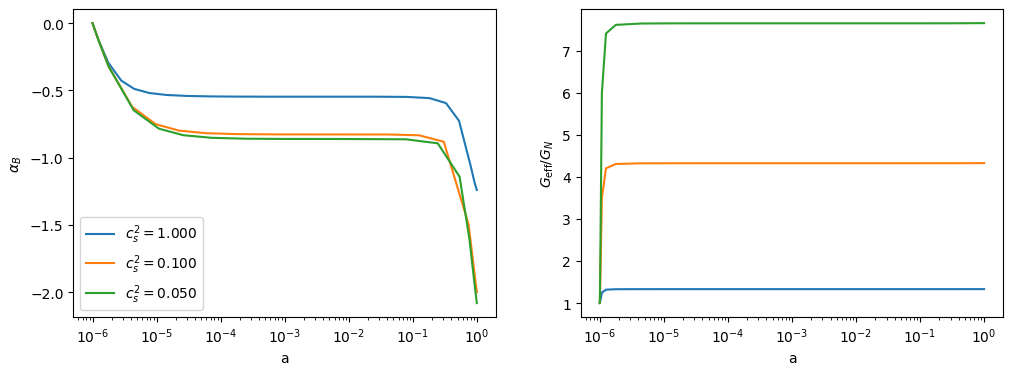

In [137]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for cs2 in [1.0, 0.1, 0.05]:
    alpha_K = 0.001
    result = solve_ivp(d_alpha_B, (np.log(a_ini), 0), y0=(1e-5,), args=(cs2, alpha_K))
    a = np.exp(result.t)
    alpha_B = result.y[0]
    G_eff = 1 + alpha_B**2/(2*cs2*(alpha_K + 1.5*alpha_B**2))
    axs[0].semilogx(a, alpha_B, label=f"$c_s^2 = {cs2:.3f}$")
    axs[1].semilogx(a, G_eff, label=f"$c_s^2 = {cs2:.3f}$")
axs[0].legend()
axs[0].set_xlabel("a")
axs[1].set_xlabel("a")
axs[0].set_ylabel(r"$\alpha_B$")
axs[1].set_ylabel(r"$G_\mathrm{eff}/G_N$")

Text(0, 0.5, '$G_\\mathrm{eff}/G_N$')

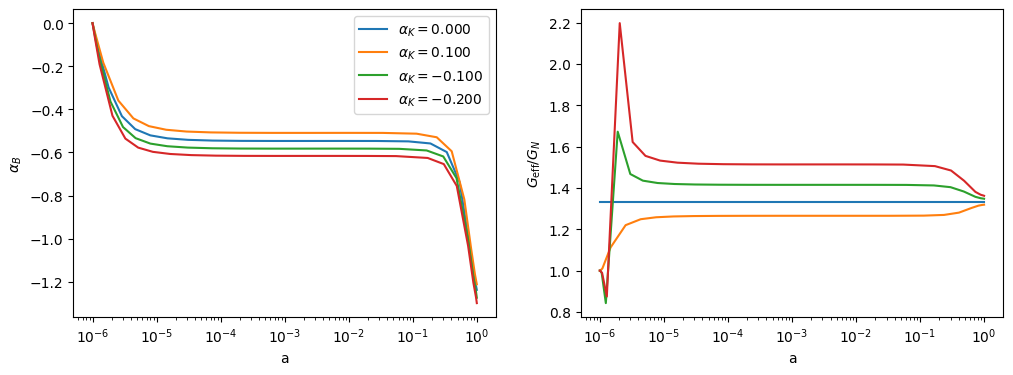

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for alpha_K in [0.0, 0.1, -0.1, -0.2]:
    cs2 = 1.0
    result = solve_ivp(d_alpha_B, (np.log(a_ini), 0), y0=(1e-5,), args=(cs2, alpha_K))
    a = np.exp(result.t)
    alpha_B = result.y[0]
    G_eff = 1 + alpha_B**2/(2*cs2*(alpha_K + 1.5*alpha_B**2))
    axs[0].semilogx(a, alpha_B, label=fr"$\alpha_K = {alpha_K:.3f}$")
    axs[1].semilogx(a, G_eff, label=fr"$\alpha_K^2 = {alpha_K:.3f}$")
axs[0].legend()
axs[0].set_xlabel("a")
axs[1].set_xlabel("a")
axs[0].set_ylabel(r"$\alpha_B$")
axs[1].set_ylabel(r"$G_\mathrm{eff}/G_N$")